In [1]:
!pip install --quiet sentence-transformers pandas scikit-learn matplotlib


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
data = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "vibes": ["boho","casual","artsy"]},
    {"name": "Street Hoodie", "desc": "Oversized black hoodie for edgy city look", "vibes": ["urban","chic","cool"]},
    {"name": "Cozy Knit Sweater", "desc": "Warm cream sweater for relaxed winter days", "vibes": ["cozy","soft","casual"]},
    {"name": "Sporty Joggers", "desc": "Lightweight joggers perfect for workouts or errands", "vibes": ["sporty","active","minimal"]},
    {"name": "Elegant Blazer", "desc": "Structured navy blazer for a sharp office vibe", "vibes": ["formal","classy","chic"]},
    {"name": "Denim Jacket", "desc": "Casual blue denim jacket with vintage wash", "vibes": ["casual","retro","urban"]},
    {"name": "Summer Sandals", "desc": "Open-toe sandals for beach and summer days", "vibes": ["boho","relaxed","vacation"]},
    {"name": "Glam Evening Gown", "desc": "Shimmery red gown for party nights", "vibes": ["glam","fancy","elegant"]}
]

df = pd.DataFrame(data)
df.head()


,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, casual, artsy]"
1,Street Hoodie,Oversized black hoodie for edgy city look,"[urban, chic, cool]"
2,Cozy Knit Sweater,Warm cream sweater for relaxed winter days,"[cozy, soft, casual]"
3,Sporty Joggers,Lightweight joggers perfect for workouts or er...,"[sporty, active, minimal]"
4,Elegant Blazer,Structured navy blazer for a sharp office vibe,"[formal, classy, chic]"


In [5]:
df["embedding"] = df["desc"].apply(lambda x: model.encode(x))


In [6]:
def get_top_matches(query, df, top_n=3):
    """
    Returns top-N product matches for a given vibe query along with latency.
    """
    start_time = time.time()

    query_emb = model.encode(query)
    df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity([x], [query_emb])[0][0])
    top_matches = df.sort_values("similarity", ascending=False).head(top_n)

    latency = time.time() - start_time

    if top_matches["similarity"].max() < 0.3:
        print("No strong vibe match found — try a different vibe ✨")

    return top_matches[["name", "desc", "similarity"]], latency


In [7]:
queries = ["boho beach vibes", "corporate classy outfit", "cozy winter look"]

results = []
for q in queries:
    top_matches, latency = get_top_matches(q, df)
    print(f"\nQuery: {q}")
    print(top_matches)
    print(f"Latency: {latency:.3f} seconds")

    # Store metrics
    results.append({
        "query": q,
        "top_match": top_matches.iloc[0]["name"],
        "similarity_score": top_matches.iloc[0]["similarity"],
        "latency_s": latency
    })

metrics_df = pd.DataFrame(results)
metrics_df



Query: boho beach vibes
             name                                            desc  similarity
0      Boho Dress          Flowy, earthy tones for festival vibes    0.377079
6  Summer Sandals      Open-toe sandals for beach and summer days    0.370350
4  Elegant Blazer  Structured navy blazer for a sharp office vibe    0.238170
Latency: 0.031 seconds

Query: corporate classy outfit
                name                                        desc  similarity
5       Denim Jacket  Casual blue denim jacket with vintage wash    0.420783
7  Glam Evening Gown          Shimmery red gown for party nights    0.403796
1      Street Hoodie   Oversized black hoodie for edgy city look    0.380759
Latency: 0.020 seconds

Query: cozy winter look
                name                                        desc  similarity
2  Cozy Knit Sweater  Warm cream sweater for relaxed winter days    0.505987
7  Glam Evening Gown          Shimmery red gown for party nights    0.395008
1      Street Hoodie 

,query,top_match,similarity_score,latency_s
0,boho beach vibes,Boho Dress,0.377079,0.030586
1,corporate classy outfit,Denim Jacket,0.420783,0.020300
2,cozy winter look,Cozy Knit Sweater,0.505987,0.019435


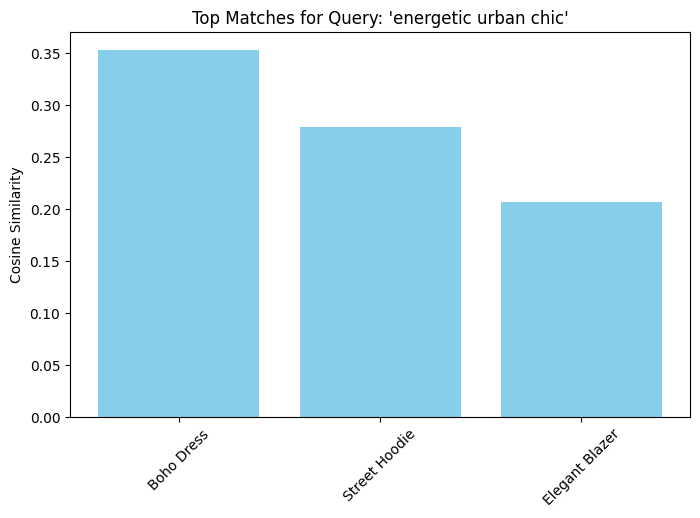

In [9]:
sample_query = "energetic urban chic"
top_matches, _ = get_top_matches(sample_query, df)

plt.figure(figsize=(8,5))
plt.bar(top_matches["name"], top_matches["similarity"], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Cosine Similarity")
plt.title(f"Top Matches for Query: '{sample_query}'")
plt.show()
